# Murat's multi-PCSF

### Murat's Algorithm
1. Obtain Z-score
2. Determine a terminal set for each patient based on Z-score. I used threshold values as 1<Z<3, 1.5<Z<3, 1.5<Z<4,
3. Compute a patient Distance Matrix, which was a total pairwise shortest paths between the terminal nodes of patient1 and patient2 divided by the union of the terminals of each patient,
4. Cluster the Distance Matrix using hierarchical clustering and obtain N clusters (I used N=10),
5. Average across the patients in the 10 clusters and do PCSF for all 10
6. Identify common Steiner nodes for each cluster and perform enrichment analysis

I did until this point, some stuff can be done to conclude the pipeline:
7. Determine the functional similarities and differences between the clusters,
8. Drill down to the structural similarity/difference (both patient-wise and cluster-wise, or within/across clusters),
9. Perform strong biological interpretation of similarities and differences

In [32]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from OmicsIntegrator import *

interactome_file = "/Users/alex/Documents/OmicsIntegrator2/data/inbiomap_exp.normalized.cleaned.connected.tsv"
graph = Graph(interactome_file, {})


In [2]:
brca = pd.read_csv('../../proteomics/data_preparation/proteomics_data/brca_inbiomap_exp.tsv', index_col=0)
brca.head()

,ZNF91,NDEL1,ELAVL1,SUMO1,SUMO3,CHMP5,UBC,HTT,E2F4,ACP5,...,SPANXN4,ZNF605,SERPINB10,ANKAR,RRH,DHH,CYSLTR1,ZNF268,COL23A1,MEDAG
AO-A12D.01TCGA,-1.102122,0.025578,0.071295,-0.225869,1.118990,-0.119194,0.0,0.166540,-0.519223,-0.747811,...,0.0,0.014149,-1.189748,0.000000,0.0,0.0,0.0,-4.001379,0.000000,0.0
C8-A131.01TCGA,-0.644553,1.901564,-0.547404,-0.369297,-1.073629,-0.786229,0.0,0.169071,0.237885,1.496776,...,0.0,-0.624314,6.163982,0.000000,0.0,0.0,0.0,3.848595,0.000000,0.0
AO-A12B.01TCGA,1.274661,0.573478,-0.263507,-1.291724,-2.197996,1.307918,0.0,0.254758,-0.371595,1.055714,...,0.0,-0.039018,-0.801173,0.000000,0.0,0.0,0.0,-1.147607,0.000000,0.0
E2-A10A.02TCGA,-9.048165,0.071716,0.055571,-6.868527,-7.366730,0.163976,0.0,-0.020544,-1.863433,1.054283,...,0.0,-12.593247,-5.277046,0.180121,0.0,0.0,0.0,0.466127,-5.390064,0.0
BH-A18Q.02TCGA,-3.728792,0.155196,0.543260,-0.617587,0.717220,-0.012073,0.0,-0.420210,1.677345,1.302662,...,0.0,-8.271821,-1.701491,-0.998961,0.0,0.0,0.0,-3.307274,-1.310081,0.0


## 1. Z-Scores

In [3]:
brca_zscore = (brca - brca.mean()) / brca.std(ddof=0)
brca_zscore.head()

,ZNF91,NDEL1,ELAVL1,SUMO1,SUMO3,CHMP5,UBC,HTT,E2F4,ACP5,...,SPANXN4,ZNF605,SERPINB10,ANKAR,RRH,DHH,CYSLTR1,ZNF268,COL23A1,MEDAG
AO-A12D.01TCGA,0.002986,-0.289911,0.062783,0.557650,0.958249,-0.171647,NaN,0.482968,-0.141760,-0.799239,...,NaN,0.714672,0.206023,-0.050453,NaN,NaN,NaN,-1.106782,0.210763,NaN
C8-A131.01TCGA,0.181735,2.125176,-0.717380,0.513374,0.271594,-1.012493,NaN,0.487304,0.421157,0.940223,...,NaN,0.552333,3.024234,-0.050453,NaN,NaN,NaN,1.331091,0.210763,NaN
AO-A12B.01TCGA,0.931475,0.415439,-0.359394,0.228626,-0.080521,1.627332,NaN,0.634128,-0.031997,0.598419,...,NaN,0.701153,0.354939,-0.050453,NaN,NaN,NaN,-0.220520,0.210763,NaN
E2-A10A.02TCGA,-3.101132,-0.230514,0.042954,-1.492905,-1.699195,0.185309,NaN,0.162404,-1.141191,0.597309,...,NaN,-2.490949,-1.360374,0.052665,NaN,NaN,NaN,0.280638,-4.178832,NaN
BH-A18Q.02TCGA,-1.023122,-0.123044,0.657917,0.436729,0.832428,-0.036613,NaN,-0.522413,1.491407,0.789793,...,NaN,-1.392161,0.009905,-0.622351,NaN,NaN,NaN,-0.891222,-0.856149,NaN


## 2. Determine a terminal set for each patient

Murat used threshold values as 1<Z<3, 1.5<Z<3, 1.5<Z<4. It's unclear why we would want to clip above, so I won't. I'll also take the abs first. 

In [4]:
brca_zscore = abs(brca_zscore)

In [5]:
len(brca_zscore.transpose())

16349

In [6]:
len(brca_zscore.where(brca_zscore > 1.5).loc['AO-A12D.01TCGA'].dropna())

1411

In [7]:
len(brca_zscore.where(brca_zscore > 2).loc['AO-A12D.01TCGA'].dropna())

581

In [8]:
brca_zscore = brca_zscore.where(brca > 2)
terminals = {patient: brca_zscore.loc[patient].dropna().index.tolist() for patient in brca_zscore.index.tolist()}

## 3. Compute a patient Distance Matrix

In [9]:
graph.interactome_graph

In [10]:
nx.number_connected_components(graph.interactome_graph)

1

### 3.1 Compute all-pairs shortest paths

In [11]:
shortest_paths = nx.all_pairs_shortest_path_length(graph.interactome_graph)

In [12]:
pickle.dump(shortest_paths, open('../data/shortest_paths.pickle', 'wb'))

sanity check:

In [13]:
sum(list(map(len, shortest_paths.values()))) == 16349**2

True

### 3.2 Define a distance metric:

In [16]:
from itertools import product

def distance(set1, set2):
    
    denominator = float(len([(a, b) for a, b in product(set1, set2) if a != b]))
    
    return sum([sum([shortest_paths[node1][node2] for node2 in set2]) for node1 in set1]) / denominator 


### 3.3 Build the distance matrix

In [17]:
matrix = pd.DataFrame({patient1: {patient2: distance(terminals1, terminals2) for patient2, terminals2 in terminals.items()} for patient1, terminals1 in terminals.items()})

In [18]:
matrix.to_pickle('../data/distance_matrix.pickle')

### 3.4 Inspect the results as a heatmap

In [3]:
matrix = pd.read_pickle('../data/distance_matrix.pickle')

In [4]:
brca_labels = pd.read_csv('../../proteomics/data_preparation/proteomics_data/raw/brca_labels.csv', index_col=0).loc['PAM50 mRNA']
brca_labels.index = brca_labels.index.str.split('.').str[0]


In [5]:
corrected_labels = matrix.index.str.replace('TCGA', '').str.split('.').str[0]
matrix.index = corrected_labels
matrix.columns = corrected_labels

In [62]:
colors = dict(zip(brca_labels.unique(), sns.husl_palette(len(brca_labels.unique()))))
colors = brca_labels.map(colors)

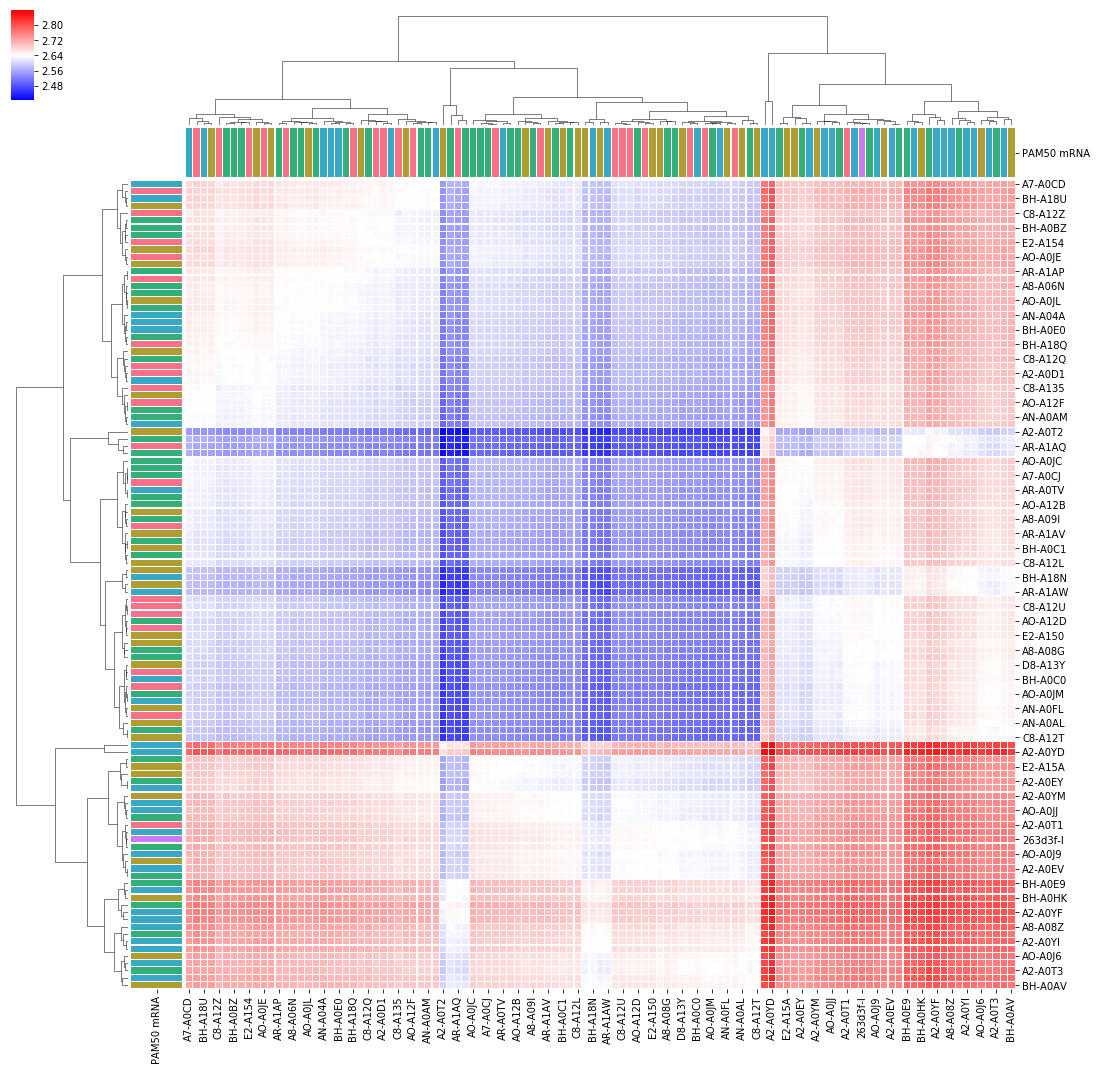

In [63]:
sns.clustermap(matrix, cmap='bwr', col_colors=colors, row_colors=colors, linewidths=.1, figsize=(18, 18))

### 3.5 Compare to patient correlation matrix

In [64]:
brca.index = corrected_labels

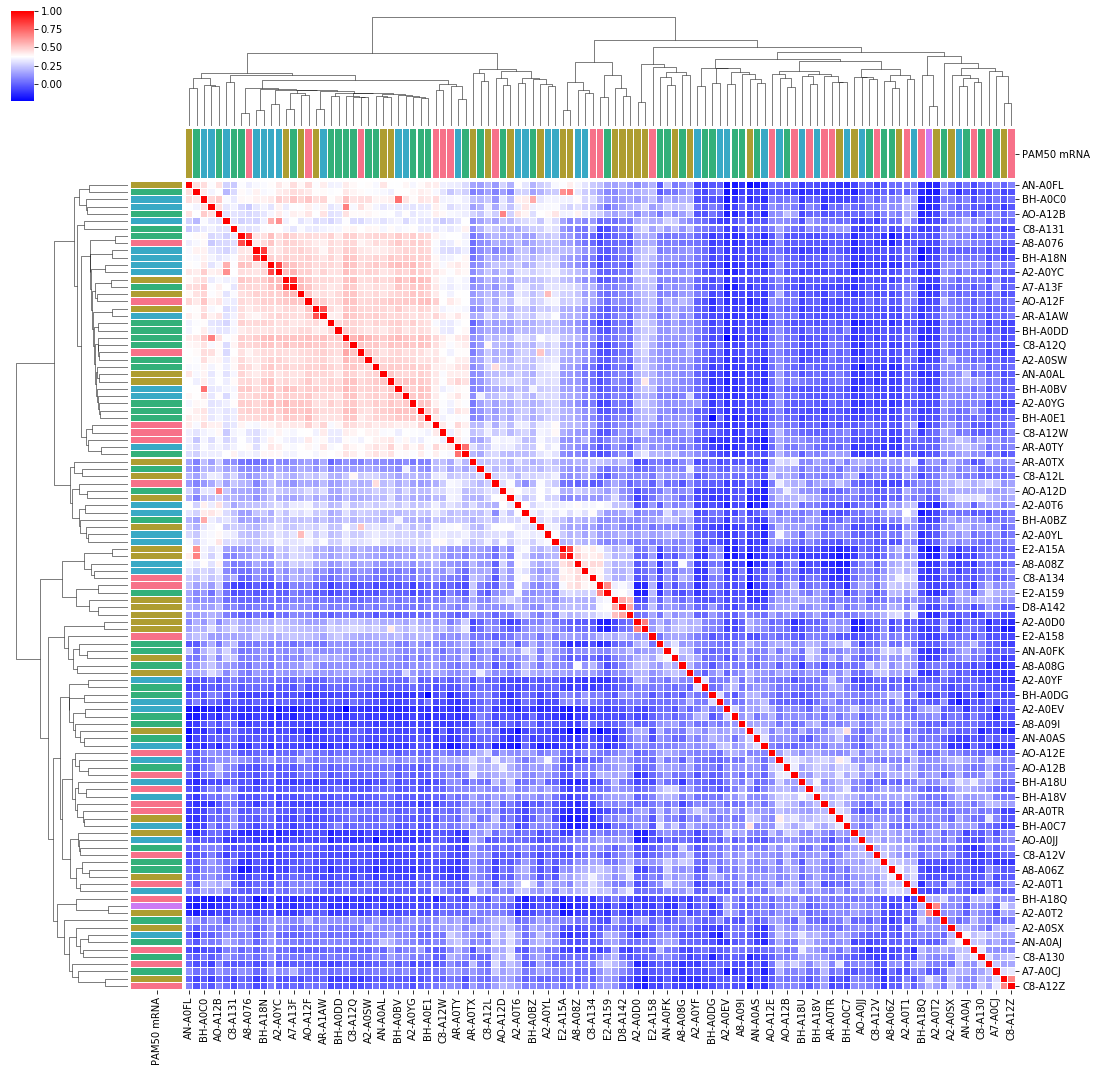

In [65]:
sns.clustermap(brca.transpose().corr(), cmap='bwr', col_colors=colors, row_colors=colors, linewidths=.1, figsize=(18, 18))

### 3.6 Normalize Patient Distance Matrix by Self-Distance

In [66]:
normalized_matrix = matrix - matrix.values.diagonal()

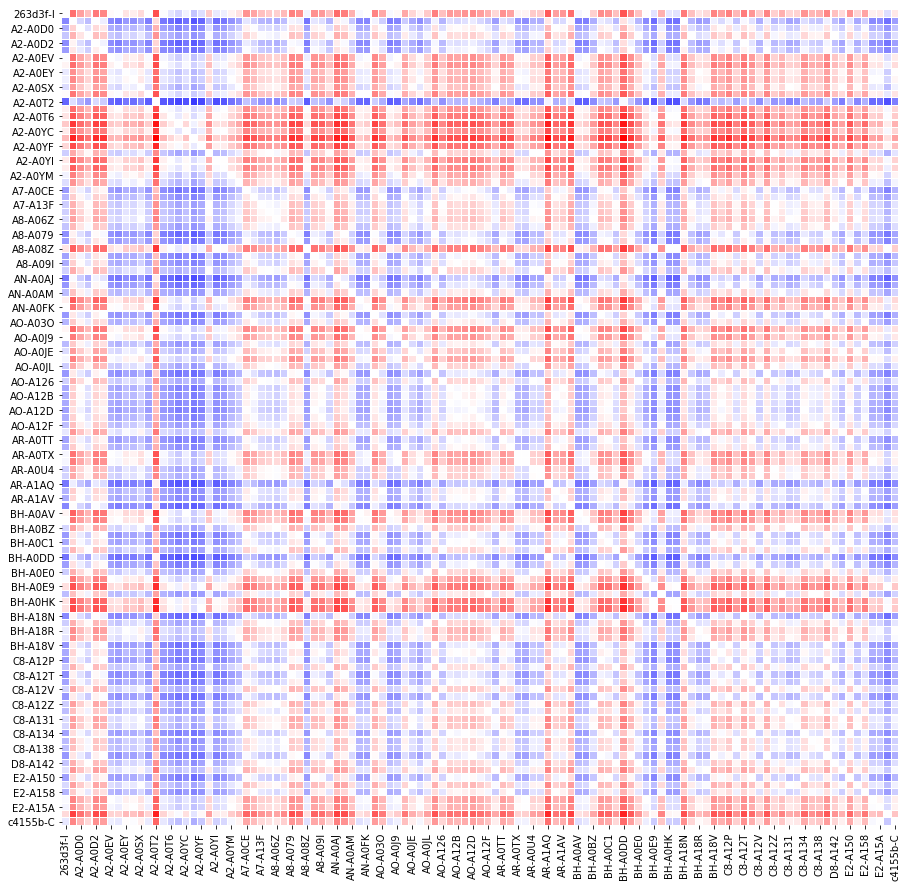

In [67]:
plt.subplots(figsize=(15,15))
sns.heatmap(normalized_matrix, cmap='bwr', center=0, linewidths=.1, cbar=False)

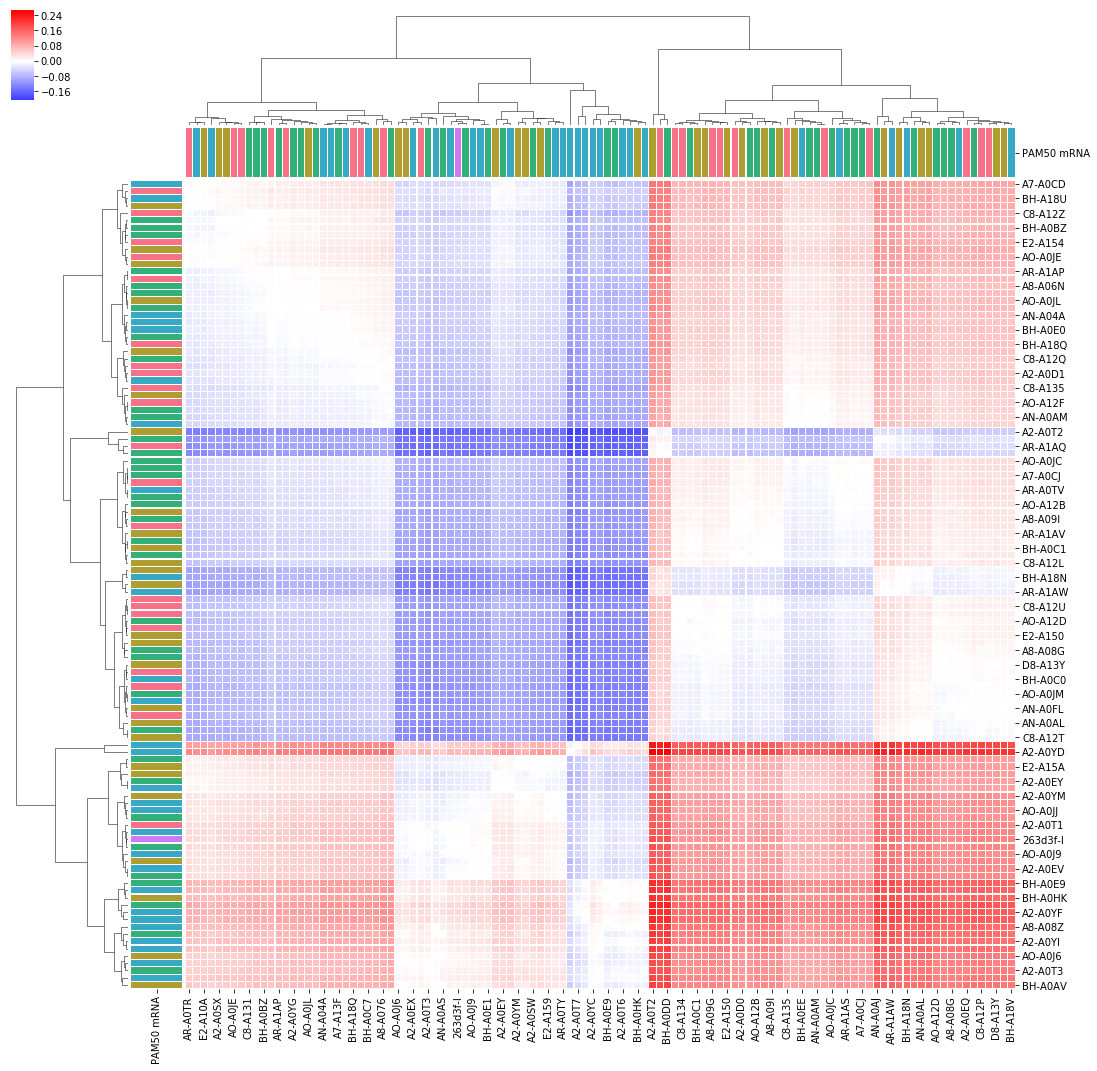

In [71]:
sns.clustermap(normalized_matrix, cmap='bwr', center=0, col_colors=colors, row_colors=colors, linewidths=.1, figsize=(18, 18))

In [93]:
final_matrix = normalized_matrix.join(brca_labels).dropna(subset=['PAM50 mRNA']).set_index('PAM50 mRNA', append=True).swaplevel().sort_index(level=0)
del final_matrix['263d3f-I'], final_matrix['blcdb9-I'], final_matrix['c4155b-C']
final_matrix

A2-A0CM   A2-A0D0   A2-A0D1   A2-A0D2   A2-A0EQ  \
PAM50 mRNA                                                                
Basal-like    A2-A0CM  0.000000 -0.042519 -0.070583 -0.001891 -0.016988   
              A2-A0D0  0.045705  0.000000 -0.031756  0.039643  0.023374   
              A2-A0D2  0.010227 -0.036463 -0.067251  0.000000 -0.012760   
              A2-A0SX  0.103904  0.056793  0.025480  0.096221  0.082220   
              A2-A0T2 -0.032455 -0.075648 -0.106452 -0.038042 -0.053880   
              A2-A0YM  0.132845  0.083557  0.050536  0.123490  0.110807   
              A7-A0CE  0.029657 -0.015038 -0.046567  0.023409  0.009442   
              AN-A0AL  0.017963 -0.026601 -0.056966  0.009092 -0.005675   
              AN-A0FL  0.023914 -0.021207 -0.051977  0.016254  0.000415   
              AO-A0J6  0.155356  0.107644  0.073806  0.146730  0.134676   
              AO-A0JL  0.088547  0.042143  0.009511  0.079780  0.067261   
              AO-A12F  0.064808  0.019148 -0.012575  0.057793  0.042458   
              AR-A0U4  0.088997  0.040116  0.008836  0.081768  0.066192   
              AR-A1AQ -0.016118 -0.058371 -0.089914 -0.024275 -0.037144   
              BH-A0AV  0.162172  0.111380  0.077413  0.152870  0.139815   
              BH-A0E0  0.082831  0.038692  0.006372  0.075754  0.061643   
              BH-A18Q  0.080328  0.033109  0.004941  0.074325  0.056922   
              BH-A18V  0.021866 -0.026218 -0.053937  0.013701 -0.001144   
              C8-A12V  0.090823  0.043473  0.012081  0.082838  0.066208   
              C8-A131  0.100601  0.054206  0.021840  0.093327  0.079704   
              C8-A131  0.100601  0.054206  0.021840  0.093327  0.079704   
              C8-A131  0.095702  0.048681  0.017031  0.088626  0.075644   
              C8-A131  0.095702  0.048681  0.017031  0.088626  0.075644   
              C8-A134  0.034478 -0.008522 -0.040870  0.027211  0.014619   
              D8-A142  0.080769  0.032321  0.001047  0.070409  0.057900   
              E2-A150  0.037908 -0.009500 -0.041367  0.029019  0.011476   
              E2-A158  0.053318  0.008459 -0.023525  0.048763  0.032684   
              E2-A159  0.126871  0.083833  0.052414  0.123397  0.111535   
HER2-enriched A2-A0D1  0.077864  0.028466  0.000000  0.069078  0.055392   
              A2-A0EQ  0.026274 -0.021588 -0.049792  0.018384  0.000000   
...                         ...       ...       ...       ...       ...   
Luminal B     A8-A06N  0.087243  0.041644  0.010122  0.080816  0.064623   
              A8-A06Z  0.097205  0.051981  0.018689  0.090128  0.074237   
              A8-A079  0.013809 -0.031351 -0.061318  0.006213 -0.008128   
              A8-A08G  0.034632 -0.010746 -0.041231  0.027163  0.010036   
              A8-A09I  0.049103  0.003443 -0.028321  0.041315  0.024435   
              AN-A0AJ -0.005152 -0.052225 -0.083762 -0.013259 -0.028861   
              AN-A0AM  0.062208  0.017425 -0.013978  0.055291  0.039253   
              AN-A0AS  0.171422  0.120539  0.085923  0.161264  0.149605   
              AN-A0FK  0.144400  0.097321  0.062625  0.135591  0.122394   
              AO-A03O  0.054884  0.010634 -0.021964  0.048981  0.032960   
              AO-A0JC  0.055492  0.011954 -0.019113  0.048355  0.032262   
              AO-A0JM  0.021264 -0.023781 -0.054096  0.012412 -0.003212   
              AO-A12B  0.044740 -0.001496 -0.032612  0.037617  0.021602   
              AO-A12B  0.044740 -0.001496 -0.032612  0.037617  0.021602   
              AO-A12B  0.051023  0.005988 -0.025874  0.044019  0.028398   
              AO-A12B  0.051023  0.005988 -0.025874  0.044019  0.028398   
              AR-A0TT  0.034704 -0.012076 -0.040492  0.027273  0.010467   
              AR-A0TV  0.052640  0.007802 -0.023507  0.045260  0.029847   
              AR-A0TY  0.134305  0.087760  0.052911  0.126592  0.112057   
              AR-A1AV  0.041180 -0.001656 -0.032647  0.034530  0.019706   
              BH-A0BZ  0.098342  0.051311  0.0178

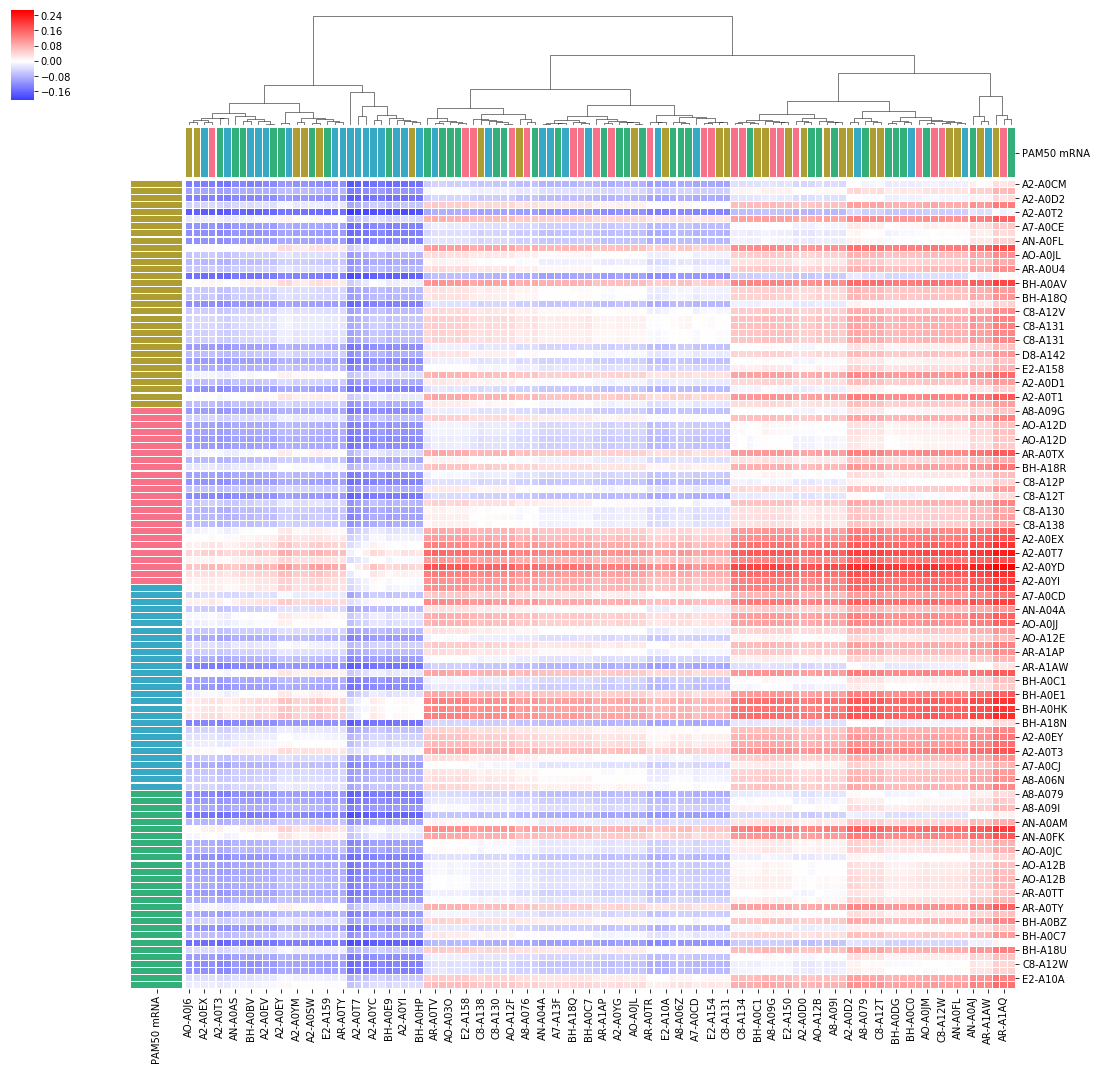

In [95]:
sns.clustermap(final_matrix.reset_index(level=0, drop=True), cmap='bwr', center=0, col_colors=colors, row_colors=colors, row_cluster=False,  linewidths=.1, figsize=(18, 18))